##### Setup
Error: the datatype for boolean values in google sheet seems to be either unretrievable or (if changed to 1 or 0) converted to float which would give an error in model run, if this can be fix

In [1]:
import sys
import os
sys.path.append('./src')
os.chdir(os.path.dirname(sys.path[0]))



# data Analysis 
import geopandas as gpd
import pandas as pd
import numpy as np



# plot
import matplotlib.pyplot as plt
import gc

# output
from output_image import write_output, analyze_model_result, output_to_csv


# multiprocessing
import multiprocessing
import brun


# model
from school_model import School

# spreadsheets
# import spreadsheets

#config
import configparser
import warnings
warnings.filterwarnings("ignore")

# Parameter Setup
Here using a test trial small schedule with 5 steps of class per day
<br>
Run for 15 days

In [2]:
map_path = "../layouts/schoollayout1/schoollayout1.shp"
schedule_path = "../schedule_data/day_schedule.csv" #small schedule has only 5 steps per day for testing purposes
#full day schedule should be "day_schedule.csv" 
schedule_steps = 90 # full day_schedule steps should be 90


# if you wish to use google sheet parameter input, you'll have to follow instructions for getting credentials of the sheet api
# follow the first two steps in:
# https://developers.google.com/sheets/api/quickstart/python
# and save your credentials in the src folder as listed below
SHEET_URL = 'https://docs.google.com/spreadsheets/d/1Quyyey5B_kdQK1_OU0OkIDGZE27tuUfjZ6hCsV99-sM'
credentials = '../src/credentials.json'


# two types of parameter setups available for batchrunner
# pre-setup for fixed/variable parameter dictionaries (consistant with mesa batchrunner)
######################
grade_N = 350
KG_N = 50
preschool_N = 50
special_education_N = 10
faculty_N = 40
seat_dist = 12
mask_prob = 0.516
days = 15
max_steps = days*schedule_steps
iterations = 1
####################

In [3]:
# fixed parameters are model input parameters that are static for all batch running jobs
fixed_parameters = {}


fixed_parameters['grade_N'] = grade_N
fixed_parameters['KG_N'] = KG_N
fixed_parameters['preschool_N'] = preschool_N
fixed_parameters['special_education_N'] = special_education_N
fixed_parameters['faculty_N'] = faculty_N
fixed_parameters['seat_dist'] = 12
fixed_parameters['init_patient'] = 3
#fixed_parameters['mask_prob'] = 0.5

# same logic as fixed parameters, only these will be batch ran for all combinations 
variable_parameters = {}
variable_parameters['attend_rate'] = [0.25, 0.5, 0.75, 1]
variable_parameters['inclass_lunch'] = [True, False]
variable_parameters['mask_prob'] = [0, 0.25, 0.5, 0.75, 1]

In [4]:
# dataframe parameter setup that can port with google sheet
# TODO: currently the sheet script cannot retrieve boolean values so this input method is not fully functioning
# namely inclass_lunch
# should be an easy fix

#param_df = spreadsheets.return_params_df(sheet_url=SHEET_URL, credentials=credentials)

# Single Run

In [5]:
school = School(map_path, schedule_path, grade_N, KG_N, preschool_N, special_education_N, 
                 faculty_N, seat_dist, init_patient=3, attend_rate=1, mask_prob=0.5, inclass_lunch=False, username="jleiucsd")


while school.running and school.schedule.steps < 1:
    school.step()

params = "{'test': 0}" 
agent_df = school.datacollector.get_agent_vars_dataframe()
model_df = school.datacollector.get_model_vars_dataframe()



In [6]:
agent_df

unique_id health_status symptoms            x            y  \
Step AgentID                                                              
0    S0             S0       healthy    False  1423.583987 -1690.866889   
     S1             S1       healthy    False  1423.583987 -1678.866889   
     S2             S2       healthy    False  1423.583987 -1666.866889   
     S3             S3       healthy    False  1423.583987 -1654.866889   
     S4             S4       healthy    False  1423.583987 -1642.866889   
...                ...           ...      ...          ...          ...   
89   10647       10647          None     None          NaN          NaN   
     10654       10654          None     None          NaN          NaN   
     10664       10664          None     None          NaN          NaN   
     90000       90000          None     None          NaN          NaN   
     90001       90001          None     None          NaN          NaN   

              viral_load  
Step AgentID              
0    S0              NaN  
     S1              NaN  
     S2              NaN  
     S3              NaN  
     S4              NaN  
...                  ...  
89   10647           0.0  
     10654           0.0  
     10664           0.0  
     90000           0.0  
     90001           0.0  

[76680 rows x 6 columns]

# Multiprocessing Run

In [4]:
if __name__ ==  '__main__': 
    # for more on multiprocessing, check src/brun 
    batchrunner = brun.BatchrunnerMP(model=School, 
                                     map_path=map_path,
                                     schedule_path=schedule_path,
                                     max_steps=max_steps, 
                                     iterations=iterations, 
                                     fixed_parameters=fixed_parameters, 
                                     variable_parameters=variable_parameters)
    results = batchrunner.run_all()

Your system has 8 available processors.


In [10]:
for params, dfs in results.items():
    #write_output(params, dfs, map_path)
    output_to_csv(params, dfs)

# Simulation Result

In [2]:
model_out_df = pd.read_csv("/oasis/scratch/comet/jleiucsd/temp_project/output_seat_dist_12_init_patient_3_attend_rate_1_inclass_lunch_True_mask_prob_0.75_iteration_0/model_val.csv")

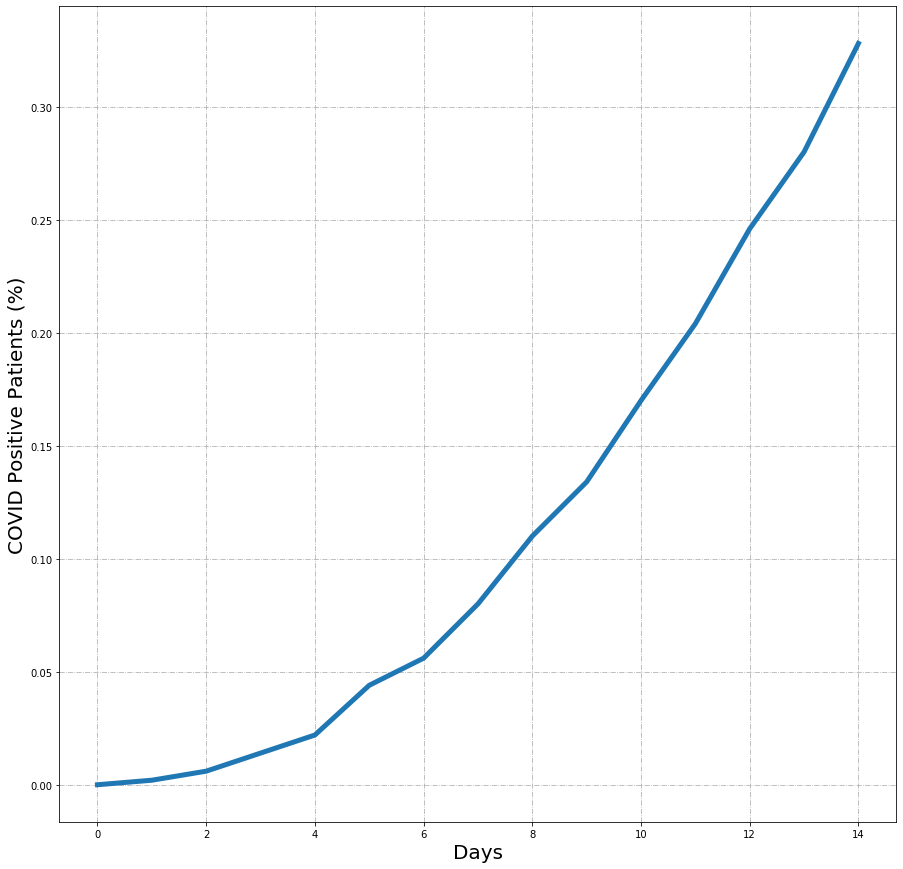

In [3]:
analyze_model_result(model_out_df=model_out_df) 